<function matplotlib.pyplot.show>

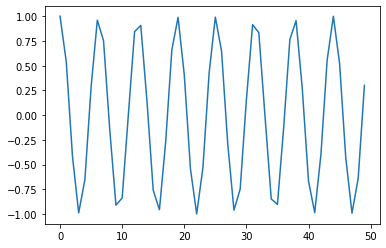

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
input_data = np.array([math.cos(x) for x in np.arange(200)])
plt.plot(input_data[:50])
plt.show

In [0]:
X = []
Y = []

size = 50
number_of_records = len(input_data) - size
for i in range(number_of_records - 50):
  X.append(input_data[i:i+size])
  Y.append(input_data[i+size])
X = np.array(X)
X = np.expand_dims(X, axis=2)
Y = np.array(Y)
Y = np.expand_dims(Y, axis=1)

In [4]:
X.shape, Y.shape

((100, 50, 1), (100, 1))

In [0]:
X_valid = []
Y_valid = []
for i in range(number_of_records - 50, number_of_records):
    X_valid.append(input_data[i:i+size])
    Y_valid.append(input_data[i+size])
X_valid = np.array(X_valid)
X_valid = np.expand_dims(X_valid, axis=2)
Y_valid = np.array(Y_valid)
Y_valid = np.expand_dims(Y_valid, axis=1)

In [0]:
learning_rate = 0.0001
number_of_epochs = 5
sequence_length = 50
hidden_layer_size = 100
output_layer_size = 1
back_prop_truncate = 5
min_clip_value = -10
max_clip_value = 10

In [0]:
W1 = np.random.uniform(0, 1, (hidden_layer_size, sequence_length))
W2 = np.random.uniform(0, 1, (hidden_layer_size, hidden_layer_size))
W3 = np.random.uniform(0, 1, (output_layer_size, hidden_layer_size))

In [0]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [11]:
for epoch in range(number_of_epochs):
  # check loss on train
  loss = 0.0
  
  # do a forward pass to get prediction
  for i in range(Y.shape[0]):
    x, y = X[i], Y[i]
    prev_act = np.zeros((hidden_layer_size, 1))
    for t in range(sequence_length):
      new_input = np.zeros(x.shape)
      new_input[t] = x[t]
      mul_w1 = np.dot(W1, new_input)
      mul_w2 = np.dot(W2, prev_act)
      add = mul_w2 + mul_w1
      act = sigmoid(add)
      mul_w3 = np.dot(W3, act)
      prev_act = act

  # calculate error 
    loss_per_record = (y - mul_w3)**2 / 2
    loss += loss_per_record
  loss = loss / float(y.shape[0])
  
  # check loss on validation
  val_loss = 0.0
  for i in range(Y_valid.shape[0]):
    x, y = X_valid[i], Y_valid[i]
    prev_act = np.zeros((hidden_layer_size, 1))
    for t in range(sequence_length):
      new_input = np.zeros(x.shape)
      new_input[t] = x[t]
      mul_w1 = np.dot(W1, new_input)
      mul_w2 = np.dot(W2, prev_act)
      add = mul_w2 + mul_w1
      act = sigmoid(add)
      mul_w3 = np.dot(W3, act)
      prev_act = act

    loss_per_record = (y - mul_w3)**2 / 2
    val_loss += loss_per_record
  val_loss = val_loss / float(y.shape[0])

  print('Epoch: ', epoch + 1, ', Loss: ', loss, ', Val Loss: ', val_loss)
  
  # train model
  for i in range(Y.shape[0]):
    x, y = X[i], Y[i]
  
    layers = []
    prev_act = np.zeros((hidden_layer_size, 1))
    dW1 = np.zeros(W1.shape)
    dW3 = np.zeros(W3.shape)
    dW2 = np.zeros(W2.shape)
    
    dW1_t = np.zeros(W1.shape)
    dW3_t = np.zeros(W3.shape)
    dW2_t = np.zeros(W2.shape)
    
    dW1_i = np.zeros(W1.shape)
    dW2_i = np.zeros(W2.shape)
    
    # forward pass
    for t in range(sequence_length):
      new_input = np.zeros(x.shape)
      new_input[t] = x[t]
      mul_w1 = np.dot(W1, new_input)
      mul_w2 = np.dot(W2, prev_act)
      add = mul_w2 + mul_w1
      act = sigmoid(add)
      mul_w3 = np.dot(W3, act)
      layers.append({'act':act, 'prev_act':prev_act})
      prev_act = act

    # derivative of pred
    dmul_w3 = (mul_w3 - y)
    
    # backward pass
    for t in range(sequence_length):
      dW3_t = np.dot(dmul_w3, np.transpose(layers[t]['act']))
      dsv = np.dot(np.transpose(W3), dmul_w3)
      
      ds = dsv
      dadd = add * (1 - add) * ds
      
      dmul_w2 = dadd * np.ones_like(mul_w2)

      dprev_act = np.dot(np.transpose(W2), dmul_w2)


      for i in range(t-1, max(-1, t-back_prop_truncate-1), -1):
        ds = dsv + dprev_act
        dadd = add * (1 - add) * ds

        dmul_w2 = dadd * np.ones_like(mul_w2)
        dmul_w1 = dadd * np.ones_like(mul_w1)

        dW2_i = np.dot(W2, layers[t]['prev_act'])
        dprev_act = np.dot(np.transpose(W2), dmul_w2)

        new_input = np.zeros(x.shape)
        new_input[t] = x[t]
        dW1_i = np.dot(W1, new_input)
        dx = np.dot(np.transpose(W1), dmul_w1)

        dW1_t += dW1_i
        dW2_t += dW2_i
        
      dW3 += dW3_t
      dW1 += dW1_t
      dW2 += dW2_t
      
      if dW1.max() > max_clip_value:
        dW1[dW1 > max_clip_value] = max_clip_value
      if dW3.max() > max_clip_value:
        dW3[dW3 > max_clip_value] = max_clip_value
      if dW2.max() > max_clip_value:
        dW2[dW2 > max_clip_value] = max_clip_value
        
      
      if dW1.min() < min_clip_value:
        dW1[dW1 < min_clip_value] = min_clip_value
      if dW3.min() < min_clip_value:
        dW3[dW3 < min_clip_value] = min_clip_value
      if dW2.min() < min_clip_value:
        dW2[dW2 < min_clip_value] = min_clip_value
    
    # update
    W1 -= learning_rate * dW1
    W3 -= learning_rate * dW3
    W2 -= learning_rate * dW2

Epoch:  1 , Loss:  [[129321.80142656]] , Val Loss:  [[64655.76954217]]
Epoch:  2 , Loss:  [[83469.71575242]] , Val Loss:  [[41730.74354188]]
Epoch:  3 , Loss:  [[47617.6300782]] , Val Loss:  [[23805.71754155]]
Epoch:  4 , Loss:  [[21765.54373458]] , Val Loss:  [[10880.69120694]]
Epoch:  5 , Loss:  [[5911.30616237]] , Val Loss:  [[2954.59044314]]


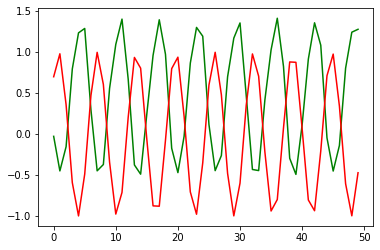

In [13]:
preds = []
for i in range(Y_valid.shape[0]):
  x, y = X_valid[i], Y_valid[i]
  prev_act = np.zeros((hidden_layer_size, 1))
  # For each time step...
  for t in range(sequence_length):
    mul_w1 = np.dot(W1, x)
    mul_w2 = np.dot(W2, prev_act)
    add = mul_w2 + mul_w1
    act = sigmoid(add)
    mul_w3 = np.dot(W3, act)
    prev_act = act

  preds.append(mul_w3)
  
preds = np.array(preds)

plt.plot(preds[:, 0, 0], 'g')
plt.plot(Y_valid[:, 0], 'r')
plt.show()

In [14]:
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(Y_valid[:, 0], preds[:, 0, 0]))

1.440276702954115